In [1]:

import vtk
import os
import numpy as np
import itertools
import math, random
import pointnetfunct.data_process_ml as data_process_ml
random.seed = 42
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils

import scipy.spatial.distance
# import plotly.graph_objects as go
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
device = "cuda"



load the dataset

In [2]:
root = "..\..\msc_data\models-v1.0\models"
IA = "aneurysms\\remeshed\\area-001"
Vessel = "vessels\\remeshed\\area-001"
IA_root = os.path.join(root,IA)
Vessel_root = os.path.join(root,Vessel)
list1 = os.listdir(Vessel_root)
list2 = os.listdir(IA_root)

In [3]:
morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data_patient = data_process_ml.read_and_combine_data(morpho_path,patient_path)
merged_dataset = data_process_ml.encode_column(morpho_data_patient)
merged_dataset = data_process_ml.drop_columns(merged_dataset)
morpho_data_cut1,morpho_data_dome = data_process_ml.output_cut1anddome(merged_dataset)

d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [4]:
import pandas as pd
from pointnetfunct.PointNet_dataset import Aneux_Dataset_load
df = pd.DataFrame()
# Aneux_Dataset = Aneuxmodel_Dataset(root = root,
#                                    df=morpho_data_patient[morpho_data_patient["cuttype"] == "dome"],
#                                    transform = transforms.ToTensor(),
#                                    mesh = "area-001",
#                                    cuttype = "dome",
#                                    crop = False)

Aneux_Dataset = Aneux_Dataset_load('./Datasets/Aneux_Dataset_1000pt_sample_600train.pt')
Aneux_Dataset_test = Aneux_Dataset_load('./Datasets/Aneux_Dataset_1000pt_sample_100test.pt')
Aneux_Dataset.paraout = True
Aneux_Dataset.cuttype = "cut1"
Aneux_Dataset_test.cuttype = "cut1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [5]:
from torch.utils.data import Subset

seed = torch.seed()
print(seed)
torch.manual_seed(32381912834800)
#12984260249700
#16912914325100

train_size = int(len(Aneux_Dataset) * 0.85) # 80% training data
valid_size = len(Aneux_Dataset) - train_size
train_data, valid_data = random_split(Aneux_Dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=50,
    shuffle=True,
    #num_workers=2, 
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    Aneux_Dataset_test,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

47232531856900


Test vaildation

# PointNet model

In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch import optim
from pointnetfunct.PointNet_struct import Tnet,Transform,PointNet,PointNet_2Multihead,PointNet_3Multihead


Run model

In [7]:
import pointnetfunct.functions
from pointnetfunct.PointNet_trainingfunct import run_model_get, load_model

pointnet = PointNet(classes=2)
run_model_get(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet,
                        results_path = "./result", 
                        filename = "/dome_1000pt_unform_test.pt",
                        model_name= "pointnet_dome_unform_1000pt_test.pth")
pointnet.to("cpu")

epoch: 0 training loss:  0.713 training accuracy:  54.9%  test loss:  0.660 test accuracy:  74.0%
epoch: 1 training loss:  0.710 training accuracy:  64.4%  test loss:  0.687 test accuracy:  69.8%
epoch: 2 training loss:  0.693 training accuracy:  66.4%  test loss:  0.664 test accuracy:  69.8%
epoch: 3 training loss:  0.699 training accuracy:  68.1%  test loss:  0.660 test accuracy:  63.5%
epoch: 4 training loss:  0.686 training accuracy:  66.6%  test loss:  0.626 test accuracy:  67.7%
epoch: 5 training loss:  0.690 training accuracy:  66.8%  test loss:  0.667 test accuracy:  69.8%
epoch: 6 training loss:  0.689 training accuracy:  67.5%  test loss:  0.672 test accuracy:  70.8%
epoch: 7 training loss:  0.696 training accuracy:  67.5%  test loss:  0.644 test accuracy:  69.8%
epoch: 8 training loss:  0.686 training accuracy:  67.0%  test loss:  0.704 test accuracy:  68.8%
epoch: 9 training loss:  0.671 training accuracy:  67.9%  test loss:  0.657 test accuracy:  68.8%
epoch: 10 training l

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [8]:
def show_graph(path,device):
    data = torch.load(path, map_location=device) # by doing map_location=device, you can use trained model on GPU --> to test on CPU
    statsrec = data["stats"]
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'test loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig.savefig("roc.svg")
    plt.show()

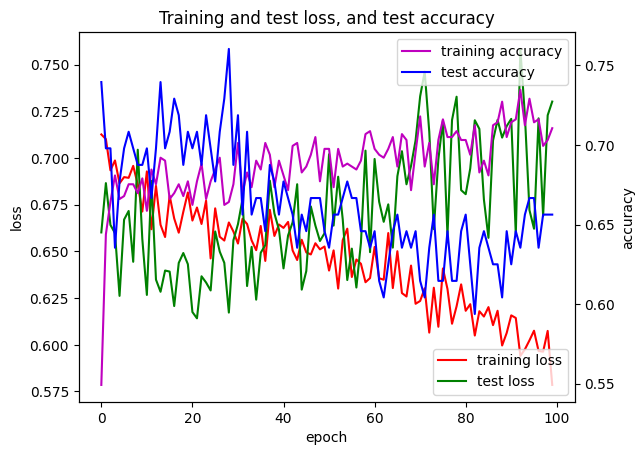

In [9]:
device = torch.device('cuda:0')
show_graph(path ="./result/dome_1000pt_unform_test.pt",device = "cuda")

In [10]:
model_path = "pointnet_dome_test.pth"
torch.save(pointnet.state_dict(), model_path)

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pointnetfunct.functions as fun
pointnet_copy = PointNet(classes=2)
model_path = "./pointnet_dome_unform_1000pt_test.pth"
load_model(pointnet_copy,model_path)
y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,_,_,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
        y_probs.extend(outputs)



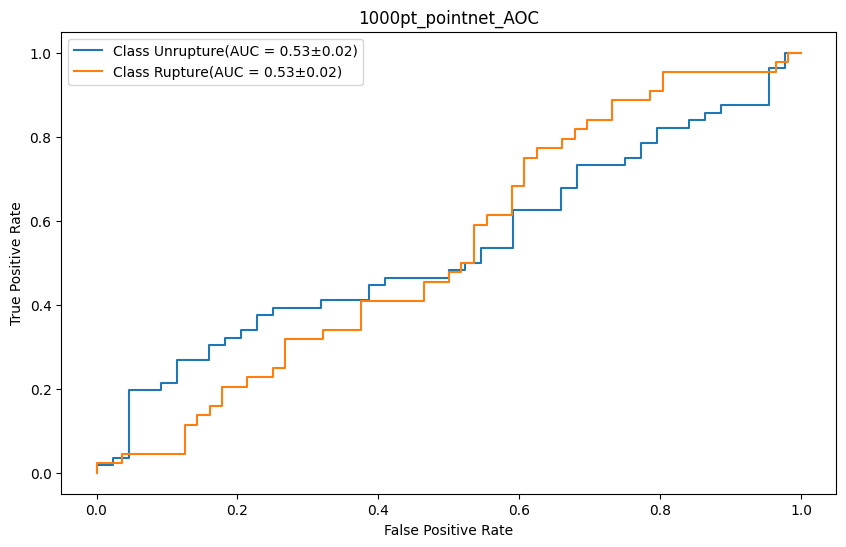

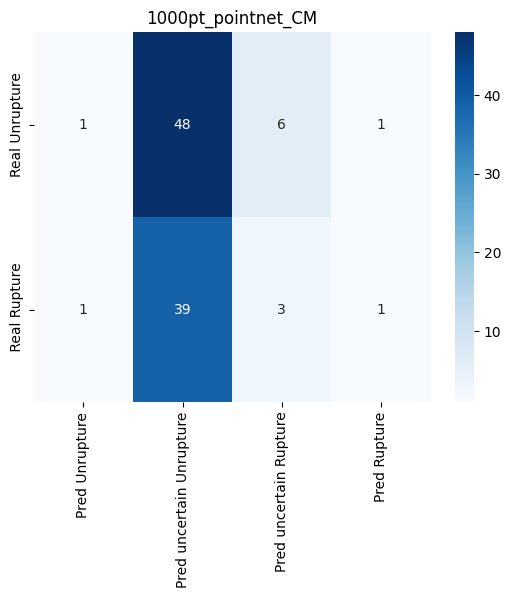

Accuracy: 0.53
F1 score: 0.14545454545454545
Rupture Recall: 0.09090909090909091
Rupture Precision: 0.36363636363636365
UnRupture Recall: 0.875
UnRupture Precision: 0.550561797752809


In [12]:
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_pointnet_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_pointnet_CM")
print_values (y_true, y_pred_result)

In [13]:

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,_,_,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
        y_probs.extend(outputs)


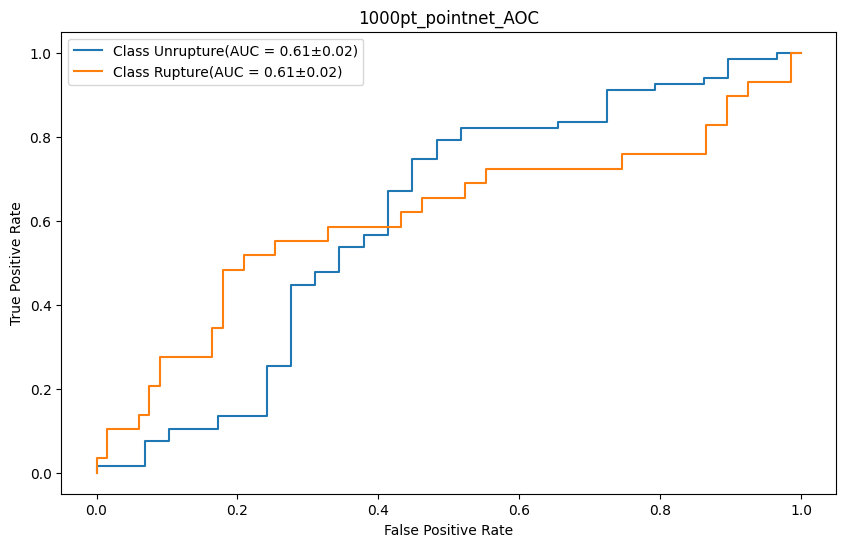

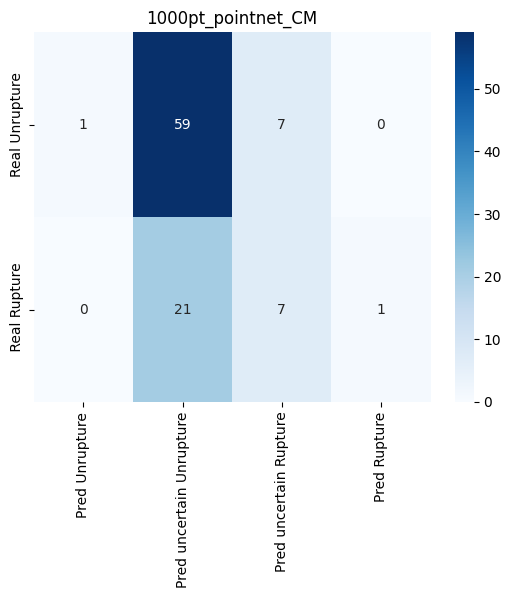

Accuracy: 0.7083333333333334
F1 score: 0.36363636363636365
Rupture Recall: 0.27586206896551724
Rupture Precision: 0.5333333333333333
UnRupture Recall: 0.8955223880597015
UnRupture Precision: 0.7407407407407407


In [14]:
draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_pointnet_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_pointnet_CM")
print_values (y_true, y_pred_result)

Multi head

2 multihead

In [15]:
import pointnetfunct.functions
from pointnetfunct.PointNet_struct import PointNet_2Multimodal_withDNN
from pointnetfunct.PointNet_trainingfunct import run_model_2multi_head_dnn
pointnet_mh = PointNet_2Multimodal_withDNN(classes=2)
run_model_2multi_head_dnn(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_mh,
                        results_path = "./result", 
                        filename = "/2multimodel_uniform_1000pt_test.pt",
                        model_name= "pointnet_2multimodal_uniform_1000pt_test.pth")

epoch: 0 training loss:  0.725 training accuracy:  58.4%  test loss:  0.686 test accuracy:  58.3%
epoch: 1 training loss:  0.687 training accuracy:  64.9%  test loss:  0.657 test accuracy:  68.8%
epoch: 2 training loss:  0.681 training accuracy:  66.8%  test loss:  0.633 test accuracy:  65.6%
epoch: 3 training loss:  0.645 training accuracy:  65.5%  test loss:  0.650 test accuracy:  69.8%
epoch: 4 training loss:  0.651 training accuracy:  71.4%  test loss:  0.660 test accuracy:  78.1%
epoch: 5 training loss:  0.601 training accuracy:  72.5%  test loss:  0.605 test accuracy:  75.0%
epoch: 6 training loss:  0.602 training accuracy:  72.7%  test loss:  0.573 test accuracy:  75.0%
epoch: 7 training loss:  0.583 training accuracy:  70.9%  test loss:  0.548 test accuracy:  76.0%
epoch: 8 training loss:  0.605 training accuracy:  71.8%  test loss:  0.548 test accuracy:  78.1%
epoch: 9 training loss:  0.591 training accuracy:  71.1%  test loss:  0.521 test accuracy:  80.2%
epoch: 10 training l

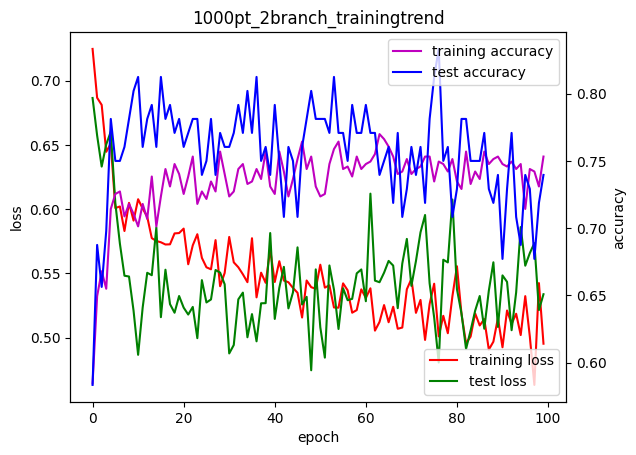

In [16]:
from pointnetfunct.evaluation import show_graph
show_graph(path ="./result/2multimodel_uniform_1000pt_test.pt",device = "cuda",name = "1000pt_2branch_trainingtrend")

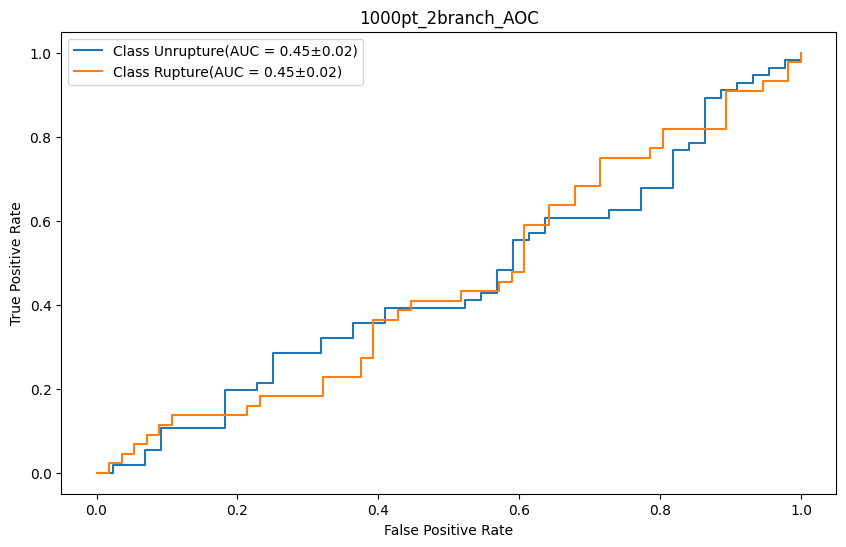

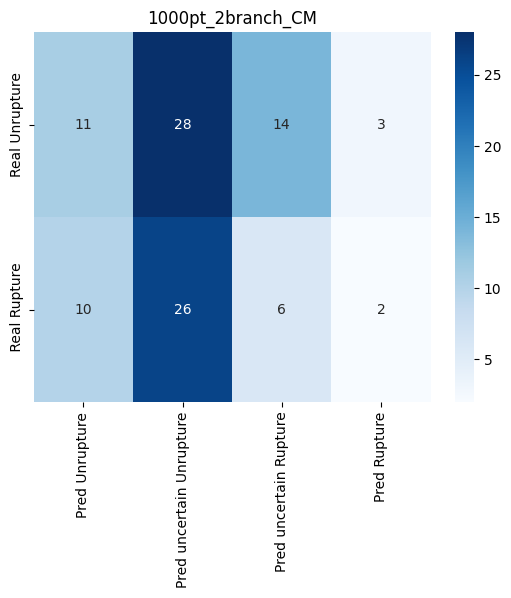

Accuracy: 0.47
F1 score: 0.2318840579710145
Rupture Recall: 0.18181818181818182
Rupture Precision: 0.32
UnRupture Recall: 0.6964285714285714
UnRupture Precision: 0.52


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pointnetfunct.functions as fun
from pointnetfunct.PointNet_trainingfunct import load_model

pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
model_path = "./pointnet_2multimodal_uniform_1000pt_test.pth"
load_model(pointnet_copy,model_path)
y_true = []
y_pred = []
y_probs = []
y_pred_result = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)
        
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_2branch_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_2branch_CM")
print_values (y_true, y_pred_result)

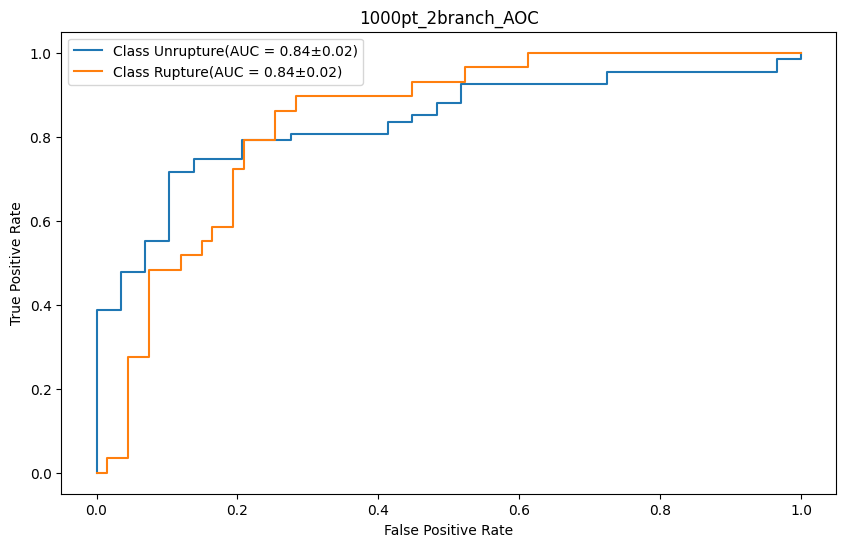

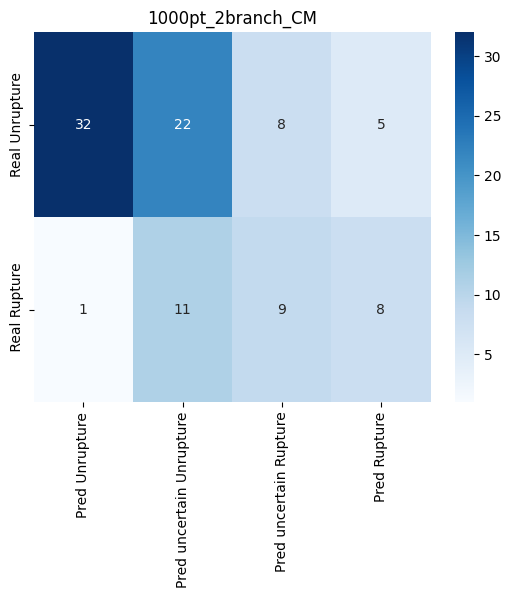

Accuracy: 0.7395833333333334
F1 score: 0.576271186440678
Rupture Recall: 0.5862068965517241
Rupture Precision: 0.5666666666666667
UnRupture Recall: 0.8059701492537313
UnRupture Precision: 0.8181818181818182


In [18]:
pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
model_path = "./pointnet_2multimodal_uniform_1000pt_test.pth"
load_model(pointnet_copy,model_path)
y_true = []
y_pred = []
y_probs = []
y_pred_result = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)
        
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_2branch_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_2branch_CM")
print_values (y_true, y_pred_result)

3multihead

In [19]:
import pointnetfunct.functions
from pointnetfunct.PointNet_struct import PointNet_3Multihead_withDNN
from pointnetfunct.PointNet_trainingfunct import run_model_3multi_head_dnn
pointnet_mh = PointNet_3Multihead_withDNN(classes=2)
run_model_3multi_head_dnn(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_mh,
                        results_path = "./result", 
                        filename = "/3multimodal_unform_1000pt_test.pt",
                        model_name= "pointnet_3multimodal_unform_1000pt_test.pth")
pointnet_mh.to("cpu")
print("done")

epoch: 0 training loss:  0.710 training accuracy:  57.7%  test loss:  0.713 test accuracy:  60.4%
epoch: 1 training loss:  0.673 training accuracy:  65.3%  test loss:  0.642 test accuracy:  66.7%
epoch: 2 training loss:  0.664 training accuracy:  68.3%  test loss:  0.582 test accuracy:  72.9%
epoch: 3 training loss:  0.680 training accuracy:  69.2%  test loss:  0.636 test accuracy:  67.7%
epoch: 4 training loss:  0.614 training accuracy:  75.1%  test loss:  0.602 test accuracy:  69.8%
epoch: 5 training loss:  0.643 training accuracy:  72.4%  test loss:  0.601 test accuracy:  71.9%
epoch: 6 training loss:  0.614 training accuracy:  71.8%  test loss:  0.572 test accuracy:  78.1%
epoch: 7 training loss:  0.607 training accuracy:  76.1%  test loss:  0.618 test accuracy:  71.9%
epoch: 8 training loss:  0.585 training accuracy:  73.5%  test loss:  0.540 test accuracy:  78.1%
epoch: 9 training loss:  0.588 training accuracy:  73.8%  test loss:  0.569 test accuracy:  74.0%
epoch: 10 training l

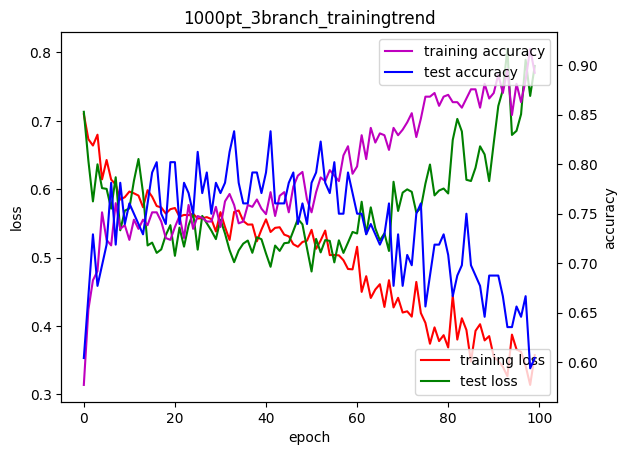

In [20]:
device = torch.device('cuda:0')
show_graph(path ="./result/3multimodal_unform_1000pt_test.pt",device = "cuda",name ="1000pt_3branch_trainingtrend")

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pointnetfunct.functions as fun
from pointnetfunct.PointNet_trainingfunct import load_model

pointnet_copy = PointNet_3Multihead_withDNN(classes=2)
model_path = "./pointnet_3multimodal_unform_1000pt_test.pth"
load_model(pointnet_copy,model_path)
y_true = []
y_pred = []
y_probs = []
y_pred_result = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v2,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)


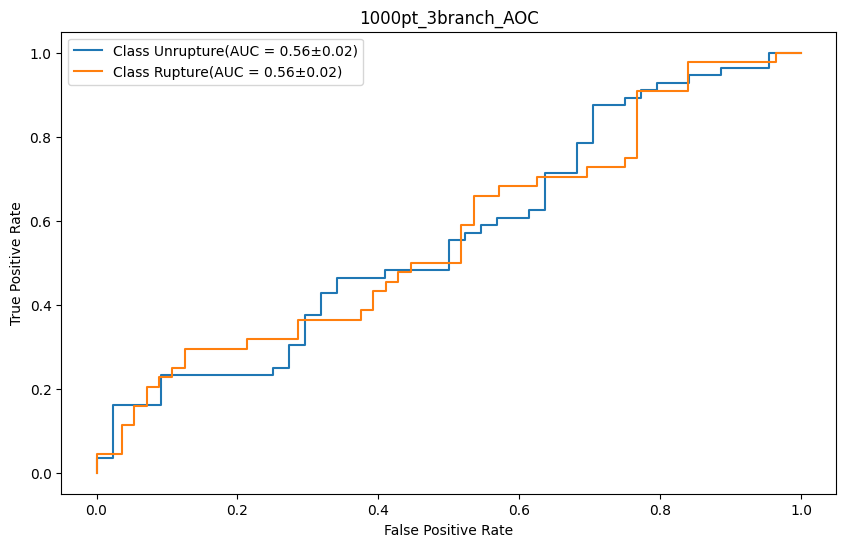

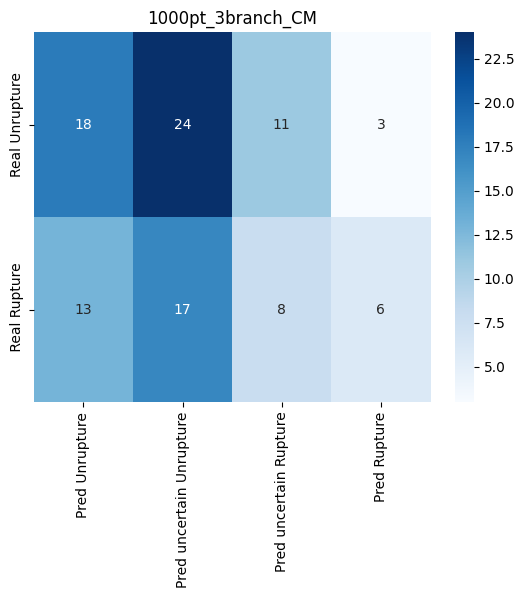

Accuracy: 0.56
F1 score: 0.3888888888888889
Rupture Recall: 0.3181818181818182
Rupture Precision: 0.5
UnRupture Recall: 0.75
UnRupture Precision: 0.5833333333333334


In [22]:
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_3branch_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_3branch_CM")
print_values (y_true, y_pred_result)

In [23]:

y_true = []
y_pred = []
y_probs = []
y_pred_result = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v2,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)
        

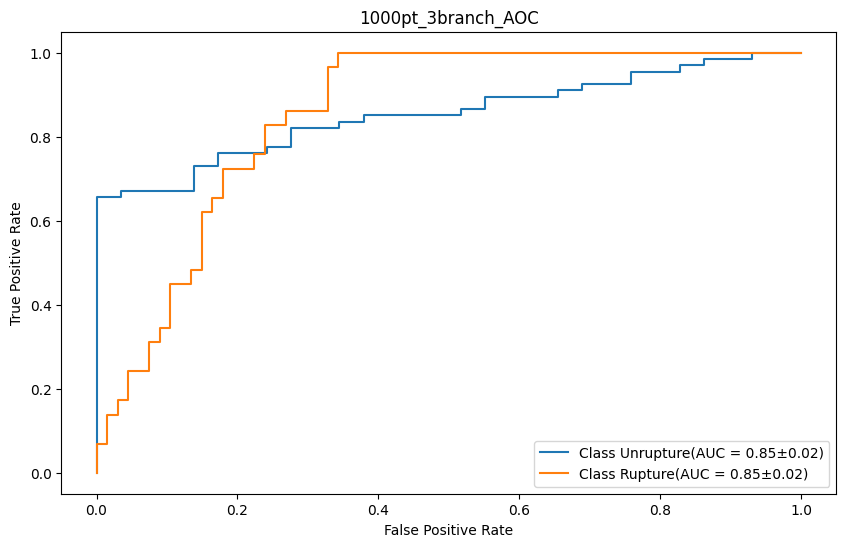

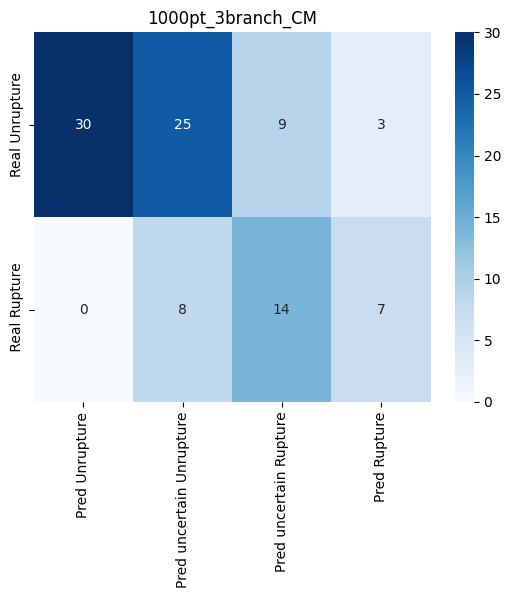

Accuracy: 0.7916666666666666
F1 score: 0.6774193548387097
Rupture Recall: 0.7241379310344828
Rupture Precision: 0.6363636363636364
UnRupture Recall: 0.8208955223880597
UnRupture Precision: 0.873015873015873


In [24]:
draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_3branch_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_3branch_CM")
print_values (y_true, y_pred_result)